# 볼 색소침착
Best hyperparameters:

{'learning_rate': 3.0207059901269228e-05, 'batch_size': 64, 'weight_decay': 5.758813276927239e-05, 'model': 'ResNetforClassification2', 'dropout': 0.4085688567343784, 'hidden_dim': 106}

model_save_path =  '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_cheek/model/model_v1/pigmentation_cheek_v2.pth'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dropout_rate = 0.4085688567343784
hidden_dim = 106
weight_decay = 5.758813276927239e-05
lr = 3.0207059901269228e-05
batch_size = 64

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

                # os.walk()를 사용하여 모든 하위 디렉토리와 파일 탐색
            for root, dirs, files in os.walk(image_folder):
                for dir_name in dirs:
                    l_r_folder_path = os.path.join(root, dir_name)
                    for root, dirs, files in os.walk(l_r_folder_path):
                        for image_file in files:
                            if image_file.endswith(('.jpg')):  # 다른 파일 형식도 포함
                                image_path = os.path.join(root, image_file)
                                image_id = image_file.split('_')[0]


                                if "r_cheek" in root:
                                    label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation'].values
                                elif "l_cheek" in root:
                                    label_data = df[df['ID'] == int(image_id)]['l_cheek_pigmentation'].values
                                else:
                                    continue

                                if len(label_data) > 0:
                                    label = label_data[0]
                                    self.image_paths.append(image_path)
                                    self.labels.append(label)

                # 넘파이 배열로 변경
                self.image_paths = np.array(self.image_paths)
                self.labels = np.array(self.labels)

                # 데이터가 비어있지 않은지 확인
                if len(self.image_paths) == 0:
                    raise ValueError("이미지 없음")

        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



# 데이터셋 준비
csv_file = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv'
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/cheek'


# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=42)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes, dropout_rate= dropout_rate, hidden_dim=hidden_dim):
        super(ResNetforClassification, self).__init__()
        # Pretrained ResNet50 모델 로드
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # ResNet50의 마지막 fc 레이어의 입력 차원 자동으로 가져오기
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Identity()  # Remove the classification head

        self.fc1 = nn.Linear(num_ftrs, hidden_dim)  # 중간 차원으로 64 선택 (언제나 바꿀 수 있음)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # 최종 출력 차원은 클래스 수

    def forward(self, image):
        image_features = self.resnet50(image) # ResNet50을 통해 이미지 특징 추출
        x = self.fc1(image_features)
        x = torch.relu(x)
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x) # 최종 FC 레이어
        return x


# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([0.9138, 0.4061], dtype=torch.float32).to(device)

num_classes = 2  # 색소침착 등급이 2개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)


# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_cheek/model/model_v1/pigmentation_cheek_v1.pth'


model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Epoch [1/50], Train Loss: 0.6589, Train Accuracy: 0.6112, Val Loss: 0.6067, Val Accuracy: 0.6684
Epoch [2/50], Train Loss: 0.4950, Train Accuracy: 0.7987, Val Loss: 0.4011, Val Accuracy: 0.8481
Epoch [3/50], Train Loss: 0.2974, Train Accuracy: 0.8853, Val Loss: 0.2994, Val Accuracy: 0.8684
Epoch [4/50], Train Loss: 0.1626, Train Accuracy: 0.9473, Val Loss: 0.2490, Val Accuracy: 0.9063
Epoch [5/50], Train Loss: 0.0883, Train Accuracy: 0.9721, Val Loss: 0.2304, Val Accuracy: 0.9241
Epoch [6/50], Train Loss: 0.0477, Train Accuracy: 0.9884, Val Loss: 0.2312, Val Accuracy: 0.9367
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.0289, Train Accuracy: 0.9927, Val Loss: 0.2339, Val Accuracy: 0.9266
EarlyStopping counter: 2 out of 5
Epoch [8/50], Train Loss: 0.0239, Train Accuracy: 0.9958, Val Loss: 0.2674, Val Accuracy: 0.9291
EarlyStopping counter: 3 out of 5
Epoch [9/50], Train Loss: 0.0163, Train Accuracy: 0.9977, Val Loss: 0.2160, Val Accuracy: 0.9342
Epoch [10/50], Train Loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

#데이터 셋 클래스 정의 (오른쪽눈가, 왼쪽눈가 구분)
class SkinDataset(Dataset):
    def __init__(self, csv_file, r_cheek_folder, l_cheek_folder, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        #csv파일 로드
        df = pd.read_csv(csv_file)

        #오른쪽 눈가 이미지 처리
        for folder in os.listdir(r_cheek_folder):
            folder_path = os.path.join(r_cheek_folder, folder)
            if os.path.isdir(folder_path):
                for image_file in os.listdir(folder_path):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder_path, image_file)
                        image_id = image_file.split('_')[0] # _기준으로 앞의 값을 id로 지정
                        label_data = df[df['ID'] == int((image_id))]['r_cheek_pigmentation'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

        #왼쪽 눈가 이미지 처리
        for folder in os.listdir(l_cheek_folder):
            folder_path = os.path.join(l_cheek_folder, folder)
            if os.path.isdir(folder_path):
                for image_file in os.listdir(folder_path):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(folder_path, image_file)
                        image_id = image_file.split('_')[0] # _기준으로 앞의 값을 id로 지정
                        label_data = df[df['ID'] == int((image_id))]['l_cheek_pigmentation'].values
                        if len(label_data) > 0:
                            label = label_data[0]
                            self.image_paths.append(image_path)
                            self.labels.append(label)

        #넘파이 배열로 변경
        self.image_paths = np.array(self.image_paths)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

#train data 구성
csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv"
r_cheek_folder = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/r_cheek"
l_cheek_folder = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/train/l_cheek"

#val data 구성
val_csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv"
val_r_cheek_folder = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/r_cheek"
val_l_cheek_folder = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/l_cheek"

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성
train_dataset = SkinDataset(csv_file=csv_file, r_cheek_folder=r_cheek_folder, l_cheek_folder=l_cheek_folder, transform=transform)
val_dataset = SkinDataset(csv_file=csv_file, r_cheek_folder=val_r_cheek_folder, l_cheek_folder=val_l_cheek_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=3)


In [ ]:
dropout_rate = 0.4085688567343784
hidden_dim = 106
weight_decay = 5.758813276927239e-05
lr = 3.0207059901269228e-05
batch_size = 64

In [ ]:
# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes, dropout_rate= dropout_rate, hidden_dim=hidden_dim):
        super(ResNetforClassification, self).__init__()
        # Pretrained ResNet50 모델 로드
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # ResNet50의 마지막 fc 레이어의 입력 차원 자동으로 가져오기
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Identity()  # Remove the classification head

        self.fc1 = nn.Linear(num_ftrs, hidden_dim)  # 중간 차원으로 64 선택 (언제나 바꿀 수 있음)
        self.dropout = nn.Dropout(p=0.4085688567343784)
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # 최종 출력 차원은 클래스 수

    def forward(self, image):
        image_features = self.resnet50(image) # ResNet50을 통해 이미지 특징 추출
        x = self.fc1(image_features)
        x = torch.relu(x)
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x) # 최종 FC 레이어
        return x

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([0.9138, 0.4061], dtype=torch.float32).to(device)

num_classes = 2
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=3.0207059901269228e-05, weight_decay=5.758813276927239e-05)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

###########################################################################################################################################################\

# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

###########################################################################################################################################################\

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict() , model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_cheek/model/model_v1/pigmentation_cheek_v2.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)


Epoch [1/50], Train Loss: 0.5133, Train Accuracy: 0.7666, Val Loss: 0.3829, Val Accuracy: 0.8376
Epoch [2/50], Train Loss: 0.2550, Train Accuracy: 0.8929, Val Loss: 0.3852, Val Accuracy: 0.8367
EarlyStopping counter: 1 out of 5
Epoch [3/50], Train Loss: 0.1270, Train Accuracy: 0.9519, Val Loss: 0.4864, Val Accuracy: 0.8299
EarlyStopping counter: 2 out of 5
Epoch [4/50], Train Loss: 0.0527, Train Accuracy: 0.9822, Val Loss: 0.6048, Val Accuracy: 0.8299
EarlyStopping counter: 3 out of 5
Epoch [5/50], Train Loss: 0.0248, Train Accuracy: 0.9928, Val Loss: 0.6502, Val Accuracy: 0.8367
EarlyStopping counter: 4 out of 5
Epoch [6/50], Train Loss: 0.0171, Train Accuracy: 0.9950, Val Loss: 0.7084, Val Accuracy: 0.8401
EarlyStopping counter: 5 out of 5
Early stopping


Accuracy: 0.8401
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75       356
           1       0.90      0.86      0.88       826

    accuracy                           0.84      1182
   macro avg       0.81      0.82      0.82      1182
weighted avg       0.85      0.84      0.84      1182



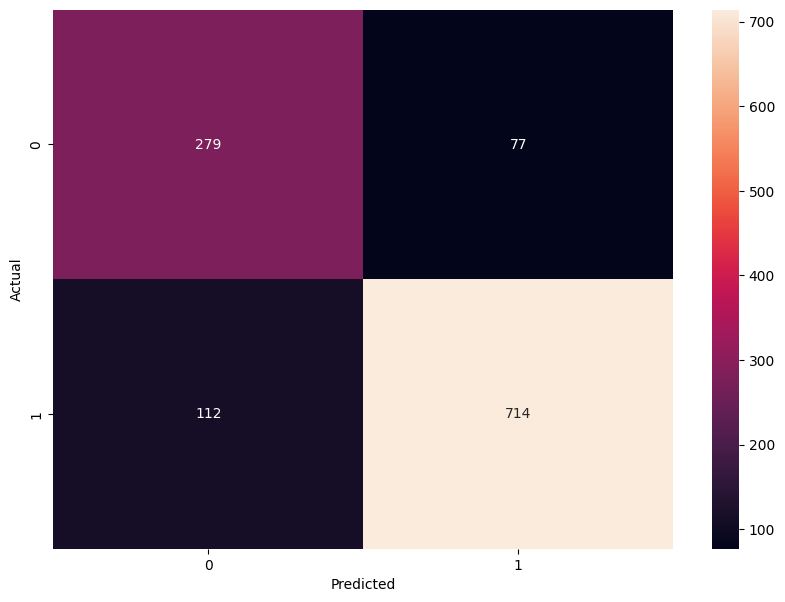

In [ ]:
#모델 평가
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가를 위한 설정
model_save_path =  '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_cheek/model/model_v1/pigmentation_cheek_v2.pth'

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델 불러오기
model = ResNetforClassification(num_classes=2).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

#데이터 셋 클래스 정의 (오른쪽눈가, 왼쪽눈가 구분)
class SkinDataset(Dataset):
    def __init__(self, csv_file, r_cheek_folders, l_cheek_folders, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # csv 파일 로드
        df = pd.read_csv(csv_file)

        for r_folder in r_cheek_folders:
            # 오른쪽 눈가 이미지 처리
            for folder in os.listdir(r_folder):
                folder_path = os.path.join(r_folder, folder)
                if os.path.isdir(folder_path):
                    for image_file in os.listdir(folder_path):
                        if image_file.endswith('.jpg'):
                            image_path = os.path.join(folder_path, image_file)
                            image_id = image_file.split('_')[0]  # _기준으로 앞의 값을 id로 지정
                            label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation'].values
                            if len(label_data) > 0:
                                label = label_data[0]
                                self.image_paths.append(image_path)
                                self.labels.append(label)

        for l_folder in l_cheek_folders:
            # 왼쪽 눈가 이미지 처리
            for folder in os.listdir(l_folder):
                folder_path = os.path.join(l_folder, folder)
                if os.path.isdir(folder_path):
                    for image_file in os.listdir(folder_path):
                        if image_file.endswith('.jpg'):
                            image_path = os.path.join(folder_path, image_file)
                            image_id = image_file.split('_')[0]  # _기준으로 앞의 값을 id로 지정
                            label_data = df[df['ID'] == int(image_id)]['l_cheek_pigmentation'].values
                            if len(label_data) > 0:
                                label = label_data[0]
                                self.image_paths.append(image_path)
                                self.labels.append(label)

        # 넘파이 배열로 변경
        self.image_paths = np.array(self.image_paths)
        self.labels = np.array(self.labels)


    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes, dropout_rate= dropout_rate, hidden_dim=hidden_dim):
        super(ResNetforClassification, self).__init__()
        # Pretrained ResNet50 모델 로드
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # ResNet50의 마지막 fc 레이어의 입력 차원 자동으로 가져오기
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Identity()  # Remove the classification head

        self.fc1 = nn.Linear(num_ftrs, hidden_dim)  # 중간 차원으로 64 선택 (언제나 바꿀 수 있음)
        self.dropout = nn.Dropout(p=0.4085688567343784)
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # 최종 출력 차원은 클래스 수

    def forward(self, image):
        image_features = self.resnet50(image) # ResNet50을 통해 이미지 특징 추출
        x = self.fc1(image_features)
        x = torch.relu(x)
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x) # 최종 FC 레이어
        return x

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([0.9138, 0.4061], dtype=torch.float32).to(device)

num_classes = 2
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=3.0207059901269228e-05, weight_decay=5.758813276927239e-05)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/annotation/annotation_class2.csv"
val_r_cheek_folder = ["/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/r_cheek/smart_pad",
                      "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/r_cheek/r_cheek_origin"]
val_l_cheek_folder = ["/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/l_cheek/smart_pad",
                      "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/data/image/Orientation/val/l_cheek/l_cheek_origin"]
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = SkinDataset(csv_file=csv_file, r_cheek_folders=val_r_cheek_folder, l_cheek_folders=val_l_cheek_folder, transform=transform)



Accuracy: 0.8401
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75       356
           1       0.90      0.86      0.88       826

    accuracy                           0.84      1182
   macro avg       0.81      0.82      0.82      1182
weighted avg       0.85      0.84      0.84      1182



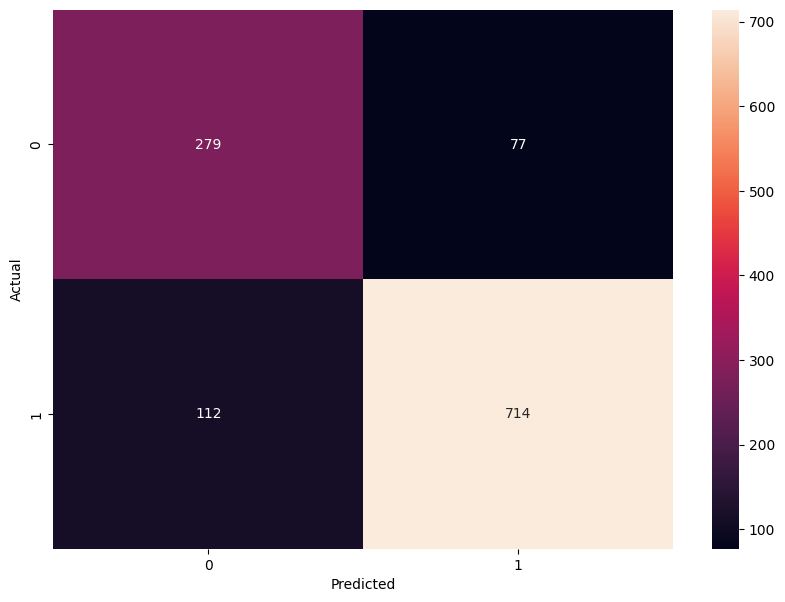

In [ ]:
#모델 평가
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_path =  '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/orientation/orientation_pigmentation_cheek/model/model_v1/pigmentation_cheek_v2.pth'

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델 불러오기
model = ResNetforClassification(num_classes=2).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()